# Автоэнкодеры в Keras

# Часть 5: GAN (Generative Adversarial Networks) и tensorflow

### Содержание

* Часть 1: Введение
* Часть 2: *Manifold learning* и скрытые (*latent*) переменные
* Часть 3: Вариационные автоэнкодеры (*VAE*)
* Часть 4: *Conditional VAE*
* **Часть 5: *GAN* (Generative Adversarial Networks) и tensorflow**
* Часть 6: *VAE* + *GAN*



При всех преймуществах вариационных автоэнкодеров ***VAE***, которыми мы занимались в предыдущих постах, они обладают одним существенным недостатком: из-за плохого способа сравнения оригинальных и восстановленных объектов, сгенерированные ими объекты хоть и похожи на объекты из обучающей выборки, но легко от них отличимы (пример, размыты). 

Этот недостаток в куда меньшей степени проявляется у другого подхода, а именно у *генеративных состязающихся сетей* - ***GAN***'ов.

Формально *GAN'ы* конечно не относятся к автоэнкодерам, однако между ними и вариационными автоэнкодерами есть сходства, они также пригодятся для следующей части. Так что не будет лишним с ними тоже познакомиться.

### Коротко о *GAN*

***GAN***'ы впервые были предложены в статье ***[1, Generative Adversarial Nets, Goodfellow et al, 2014]***
и сейчас очень активно исследуются. Наиболее state-of-the-art генеративные модели так или иначе используют *adversarial*.

***GAN***'ы состоят из 2 нейронных сетей: 
- 1-ая - генератор сэмплит случайные числа из какого-то заданного распределения $P(Z)$, например $N(0,I)$ и генерируют из них объекты $X_p = G(Z; \theta_g)$, которые идут на вход второй сети,
- 2-ая - дискриминатор получает на вход объекты из выборки $X_s$ и созданные генератором $X_p$, и учится предсказывать вероятность того, что конкретный объект реальный, выдавая скаляр $D(X; \theta_d)$.

Схема ***GAN***:
![](figs5/GAN.png)

При этом генератор тренируется создавать объекты, который дискриминатор не отличит от реальных.  

----
**Рассмотрим процесс обучения *GAN*.**  

Генератор и дискриминатор обучаются отдельно, но в рамках одной сети.  

Делаем k шагов обучения дискриминатора: за шаг обучения дискриминатора параметры $\theta_d$ обновляются в сторону уменьшения кросс-энтропии:

$$
\theta_d = \theta_d - ∇_{\theta_d} \left(\log(D(X_s)) + \log(1 - D(G(Z))) \right)
$$

Далее шаг обучения генератора: обновляем параметры генератора $\theta_g$ в сторону увеличения логарифма вероятности дискриминатору присвоить сгенерированному объекту лейбл реального.

$$
\theta_g = \theta_g + ∇_{\theta_g} \log(1 - D(G(Z)))
$$


Схема обучения:
![](figs5/GAN_bp_dis_gen.png)

На левой картинке шаг обучения дискриминатора: градиент (красные стрелки) протекает от лосса только до дискриминатора, где обновляются $\theta_d$ (зеленые) в сторону уменьшения лосса. На правой картинке градиент от правой части лосса (ошибка идентификации сгенерированного объекта) протекает до генератора, при этом обновляются только веса генератора $\theta_g$ (зеленые) в сторону **увеличения** вероятности дискриминатора ошибиться.

Задача, которую решает *GAN* формулируется так:

$$
\min_G \max_D \mathbb{E}_{X \sim P}[ \log(D(X))] + \mathbb{E}_{Z \sim P_z}[ \log(1 - D(G(Z)))]
$$

В ***[1]*** показывается, что при достаточной мощности обеих сетей у данной задачи есть оптимум, в котором генератор научился генерировать распределение $P_g(X)$ совпадающее с $P(X)$, а везде на $X$ дискриминатор выдает вероятность $1/2$.

![](figs5/GAN_learning.png)

Иллюстрация из ***[1]***  

Обозначения:
- черная точечная кривая - настоящее распределение $P(X)$, 
- зеленая - распределение генератора $P_g(X)$, 
- синяя - распределение вероятности $D(X;\theta_d)$ дискриминатора предсказать класс реального объекта,
- нижняя и верхняя прямые - множество всех $Z$ и множество всех $X$, стрелочки олицетворяют отображение $G(Z;\theta_g)$.

На картинке:
- (a) $P(X)$ и $P_g(X)$ довольно разные, но дискриминатор не уверено отличает одно от другого, 
- (b) дискриминатор после k шагов обучения уже отличает их увереннее, 
- (c) это позволяет генератору $G$ руководствуясь хорошим градиентом дискриминатора $D$ на границе двух распределений подвинуть $P_g(X)$ ближе к $P(X)$,
- (d) в результате многих повторений шагов (а), (b), (c) $P_g$ совпало с $P$ и дискриминатор более не способен отличать одно от другого: $D(X) = 1/2$. Точка оптимума достигнута.

## Conditional GAN

Точно как в прошлой части мы сделали *Conditional VAE* просто передавая в энкодер и декодер лейбл цифры, здесь мы будем передавать его в генератор и дискриминатор ***[2]***

![](figs5/CGAN.png)

## Код
В отличие от предыдущих частей, где получалось обходиться одним *keras'ом*, здесь с этим возникает проблема. А именно, нужно в одной и той же сети по-очереди обновлять либо только параметры генератора, либо только дискриминатора. Если исхитриться, то можно сделать это и чисто в *keras'е*, но по мне проще и полезнее подключить сюда и *tensorflow*.
В блоге *keras'а* есть небольшой [туториал](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html) ***[3]***  как это делать.

Благо *keras* легко сочетается с *tensorflow* - не даром он попал в *tensorflow.contrib*.

Начнем с импортирования нужных модулей и загрузки датасета

In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dropout, BatchNormalization, Reshape, Flatten, RepeatVector
from keras.layers import Lambda, Dense, Input, Conv2D, MaxPool2D, UpSampling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, load_model


from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)

Using TensorFlow backend.


Для работы в *keras* и *tensorflow* одновременно, надо зарегистрировать *tensorflow* сессию в *keras*, это нужно для того, чтобы *keras* создавал все внутренние переменные в рамках используемой сессии.

In [2]:
from keras import backend as K
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Определим основные глобальные константы

In [3]:
batch_size = 256
batch_shape = (batch_size, 28, 28, 1)
latent_dim = 2
num_classes = 10
dropout_rate = 0.3

Обучать модель мы теперь будем не с помощью метода *.fit*, а напрямую из *tensorflow*, поэтому напишем итератор, возвращающий очередной батч

In [4]:
def gen_batch(x, y):
    n_batches = x.shape[0] // batch_size
    while(True):
        for i in range(n_batches):
            yield x[batch_size*i: batch_size*(i+1)], y[batch_size*i: batch_size*(i+1)]
        idxs = np.random.permutation(y.shape[0])
        x = x[idxs]
        y = y[idxs]


train_batches_it = gen_batch(x_train, y_train_cat)
test_batches_it  = gen_batch(x_test,  y_test_cat)

Оборачиваем *placeholder*'ы для картинок, лейблов и скрытых переменных во входящие слои для *keras* моделей

In [5]:
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1),   name='image')
y_ = tf.placeholder(tf.float32, shape=(None, num_classes), name='labels')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim),  name='z')

img = Input(tensor=x_)
lbl = Input(tensor=y_)
z   = Input(tensor=z_)

Реализовывать будем сразу ***CGAN***, так как он лишь минимально отличается от обычного.  
Напишем модель генератора. *Keras* работает со *scope'ами*, а нам нужно разделить генератор и дикриминатор, чтобы потом обучать их по-отдельности

In [6]:
with tf.variable_scope('generator'):
    x = concatenate([z, lbl])
    x = Dense(7*7*64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Reshape((7, 7, 64))(x)
    x = UpSampling2D(size=(2, 2))(x)

    x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = UpSampling2D(size=(2, 2))(x)

    generated = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
generator = Model([z, lbl], generated, name='generator')

Далее, модель дискриминатора. Здесь нам нужно добавить ко входящему изображению еще лейбл цифры. Для этого после применения первого сверточного слоя, добавим к фильтрам лейблы. Сперва функция, которая это делает, потом модель дискриминатора

In [7]:
def add_units_to_conv2d(conv2, units):
    dim1 = int(conv2.shape[1])
    dim2 = int(conv2.shape[2])
    dimc = int(units.shape[1])
    repeat_n = dim1*dim2
    units_repeat = RepeatVector(repeat_n)(lbl)
    units_repeat = Reshape((dim1, dim2, dimc))(units_repeat)
    return concatenate([conv2, units_repeat])


with tf.variable_scope('discrim'):
    x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
    x = add_units_to_conv2d(x, lbl)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    
    l = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(l)
    x = Dropout(dropout_rate)(x)

    h = Flatten()(x)
    d = Dense(1, activation='sigmoid')(h)
discrim = Model([img, lbl], d, name='Discriminator')

Определив модели, мы можем применять их напрямую к *placeholder'ам* как обычные *tensorflow* операции

In [8]:
generated_z = generator([z, lbl])

discr_img   = discrim([img, lbl])
discr_gen_z = discrim([generated_z, lbl])

gan_model = Model([z, lbl], discr_gen_z, name='GAN')
gan   = gan_model([z, lbl])

Теперь лосс ошибки определения реального изображения, и лосс сгенерированного, а также на их основе лоссы генератора и дискриминатора

In [9]:
log_dis_img   = tf.reduce_mean(-tf.log(discr_img + 1e-10))
log_dis_gen_z = tf.reduce_mean(-tf.log(1. - discr_gen_z + 1e-10))

L_gen = -log_dis_gen_z
L_dis = 0.5*(log_dis_gen_z + log_dis_img)

Обычно в *tensorflow*, передавая в оптимизатор лосс, он будет пытаться минимизировать сразу все переменные, от которых он зависит. Нам сейчас этого не надо: обучая генератор, ошибка не должна трогать дискриминатор, хотя должна сквозь него течь и наоборот.

Для этого дополнительно в оптимизатор надо передать список переменных которые он будет оптимизировать. Достанем эти переменные из нужных *scope'ов* с помощью *tf.get_collection*

In [10]:
optimizer_gen = tf.train.RMSPropOptimizer(0.0003)
optimizer_dis = tf.train.RMSPropOptimizer(0.0001)

# Переменные генератора и дискриминаторы (отдельно) для оптимизаторов
generator_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
discrim_vars   = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discrim")

step_gen = optimizer_gen.minimize(L_gen, var_list=generator_vars)
step_dis = optimizer_dis.minimize(L_dis, var_list=discrim_vars)

Инициализируем переменные

In [11]:
sess.run(tf.global_variables_initializer())

Отдельно напишем функции, которые будем вызывать для обучения генератора и дискриминатора

In [12]:
# Шаг обучения генератора
def step(image, label, zp):
    l_dis, _ = sess.run([L_dis, step_gen], feed_dict={z:zp, lbl:label, img:image, K.learning_phase():1})
    return l_dis

# Шаг обучения дискриминатора
def step_d(image, label, zp):
    l_dis, _ = sess.run([L_dis, step_dis], feed_dict={z:zp, lbl:label, img:image, K.learning_phase():1})
    return l_dis

Код сохранения и визуализации картинок (скрыто)

In [ ]:
# Массивы в которые будем сохранять результаты, для последующей визуализации
figs = [[] for x in range(num_classes)]
periods = []

save_periods = list(range(100)) + list(range(100, 1000, 10))

n = 15 # Картинка с 15x15 цифр
from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры берем из обратной функции распределения
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
def draw_manifold(label, show=True):
    # Рисование цифр из многообразия
    figure = np.zeros((28 * n, 28 * n))
    input_lbl = np.zeros((1, 10))
    input_lbl[0, label] = 1.
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])

            x_generated = sess.run(generated_z, feed_dict={z:z_sample, lbl:input_lbl, K.learning_phase():0})
            digit = x_generated[0].squeeze()
            figure[i * 28: (i + 1) * 28,
                   j * 28: (j + 1) * 28] = digit
    if show:
        # Визуализация
        plt.figure(figsize=(10, 10))
        plt.imshow(figure, cmap='Greys')
        plt.grid(False)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
    return figure


n_compare = 10
def on_n_period(period):
    clear_output() # Не захламляем output

    # Рисование многообразия для рандомного y
    draw_lbl = np.random.randint(0, num_classes)    
    print(draw_lbl)
    for label in range(num_classes):
        figs[label].append(draw_manifold(label, show=label==draw_lbl))

    periods.append(period)

Обучим теперь наш *CGAN*.  
Важно, чтобы в самом начале дискриминатор не слишком побеждать стал, иначе обучение остановится. Поэтому здесь добавлены внутренние циклы как для дискриминатора, так и для генератора, и выход из них, когда одна сеть почти догоняет другую.  
Если дискриминатор сразу выигрывает у декодера и обучение даже не успевает начаться, то можно попробовать замедлить обучение дискриминатора, либо несколько раз начинать заного.

9


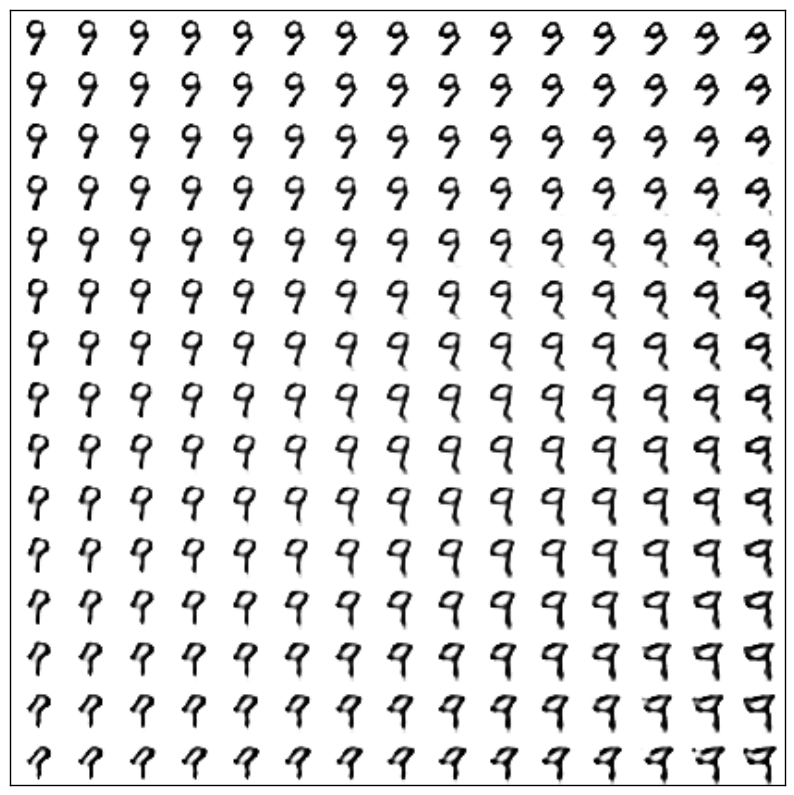

0.666782
..............

In [ ]:
batches_per_period = 20 # Как часто сохранять картинки
k_step = 5 # Количество шагов, которые могут делать дискриминатор и генератор во внутреннем цикле

for i in range(5000):
    print('.', end='')
    # Достанем новый батч
    b0, b1 = next(train_batches_it)
    zp = np.random.randn(batch_size, latent_dim)
    # Шаги обучения дискриминатора
    for j in range(k_step):
        l_d = step_d(b0, b1, zp)
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)
        if l_d < 1.0:
            break

#     Шаги обучения генератора
    for j in range(k_step):
        l_d = step(b0, b1, zp)
        if l_d > 0.4:
            break
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)

    # Периодическое рисование результата
    if not i % batches_per_period:
        period = i // batches_per_period
        if period in save_periods:
            on_n_period(period)
        print(l_d)

Код рисования гифок: (скрыто)

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib

def make_2d_figs_gif(figs, periods, c, fname, fig, batches_per_period): 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28,28)), cmap='Greys', norm=norm)
    plt.grid(None)
    plt.title("Label: {}\nBatch: {}".format(c, 0))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Label: {}\nBatch: {}".format(c, periods[i]*batches_per_period))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, dpi=80, writer='imagemagick')

for label in range(num_classes):
    make_2d_figs_gif(figs[label], periods, label, "./figs4_5/manifold_{}.gif".format(label), plt.figure(figsize=(10,10)), batches_per_period)

## Результаты:

### GAN
Многообразие цифр для обычного *GAN* (без передачи лейблов)
<img src="./figs5/GAN_manifold.png" width="600"/>
Стоит отметить, что цифры получаются лучше, чем в *VAE* (без лейблов)  
Гифка обучения: (скрыто)
<img src="./figs5/manifold_all.gif" width="600"/>

### CGAN
Многообразия цифр для каждого лейбла
<img src="./figs5/manifold_0.png" width="600"/>
<img src="./figs5/manifold_1.png" width="600"/>
<img src="./figs5/manifold_2.png" width="600"/>
<img src="./figs5/manifold_3.png" width="600"/>
<img src="./figs5/manifold_4.png" width="600"/>
<img src="./figs5/manifold_5.png" width="600"/>
<img src="./figs5/manifold_6.png" width="600"/>
<img src="./figs5/manifold_7.png" width="600"/>
<img src="./figs5/manifold_8.png" width="600"/>
<img src="./figs5/manifold_9.png" width="600"/>

Гифки обучения: (скрыто)
<img src="./figs5/manifold_0.gif" width="600"/>
<img src="./figs5/manifold_1.gif" width="600"/>
<img src="./figs5/manifold_2.gif" width="600"/>
<img src="./figs5/manifold_3.gif" width="600"/>
<img src="./figs5/manifold_4.gif" width="600"/>
<img src="./figs5/manifold_5.gif" width="600"/>
<img src="./figs5/manifold_6.gif" width="600"/>
<img src="./figs5/manifold_7.gif" width="600"/>
<img src="./figs5/manifold_8.gif" width="600"/>
<img src="./figs5/manifold_9.gif" width="600"/>

## Полезные ссылки и литература

Оригинальная статья:  
[1] Generative Adversarial Nets, Goodfellow et al, 2014, https://arxiv.org/abs/1406.2661

Conditional GANs:  
[2] Conditional Generative Adversarial Nets, Mirza, Osindero, 2014, https://arxiv.org/abs/1411.1784

Туториал про использование *keras* вместе с *tensorflow*:  
[3] https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html